In [3]:
# import numpy as np
# import os
# from tqdm import tqdm
# from ase.lattice.cubic import BodyCenteredCubic
# from ase.io import write
# from pymatgen.io.ase import AseAtomsAdaptor
# from pymatgen.io.vasp.sets import MPRelaxSet

# # --- User parameters ---
# num_points = 7
# max_strain = 0.01  # ±1% strain
# base_dir = "vasp_inputs_elastic"  # folder where inputs will be stored

# # --- Initialize BCC Ta structure ---
# atoms = BodyCenteredCubic('Ta')
# cell0 = atoms.get_cell().copy()

# # --- Strain types ---
# strain_types = {
#     "C11": {"type": "normal", "strain_dir": 0},
#     "C12": {"type": "normal", "strain_dir": 1},
#     "C44": {"type": "shear",  "strain_dir": (0, 1)},
# }

# # Create base directory
# os.makedirs(base_dir, exist_ok=True)

# # --- Loop over strain types ---
# for label, info in strain_types.items():
#     strains = np.linspace(-max_strain, max_strain, num_points)

#     for eps in tqdm(strains, desc=f"Generating VASP inputs for {label}"):
#         strain_matrix = np.eye(3)

#         # Apply the appropriate strain
#         if info["type"] == "shear":
#             i, j = info["strain_dir"]
#             strain_matrix[i, j] = eps
#         else:
#             i = info["strain_dir"]
#             strain_matrix[i, i] = 1 + eps

#         # Deform the structure
#         new_cell = np.dot(cell0, strain_matrix)
#         atoms.set_cell(new_cell, scale_atoms=True)

#         # Convert to pymatgen structure
#         structure = AseAtomsAdaptor.get_structure(atoms)

#         # Create VASP input set using MPRelaxSet
#         vis = MPRelaxSet(
#             structure,
#             user_incar_settings={
#                 "EDIFF": 1e-7,
#                 "ISIF": 2,  # relax ions only, keep cell fixed
#                 "IBRION": 2,
#                 "NSW": 200,
#                 "PREC": "Accurate",
#                 "ISMEAR": 1,
#                 "SIGMA": 0.2,
#             },
#             user_kpoints_settings={"reciprocal_density": 1000}
#         )

#         # Create folder name (e.g., C11_eps_+0.0050)
#         folder_name = f"{label}_eps_{eps:+.4f}"
#         folder_path = os.path.join(base_dir, folder_name)
#         os.makedirs(folder_path, exist_ok=True)

#         # Write POSCAR and INCAR/KPOINTS/POTCAR files
#         vis.write_input(folder_path)

#         # Also save POSCAR from ASE for reference
#         write(os.path.join(folder_path, "POSCAR_from_ASE"), atoms, format="vasp")

# print(f"\n✅ VASP input files generated in '{base_dir}/' for all strain configurations.")
# print("Run VASP in each folder to calculate the stress tensors.")


## Extract the stress data and do the fitting

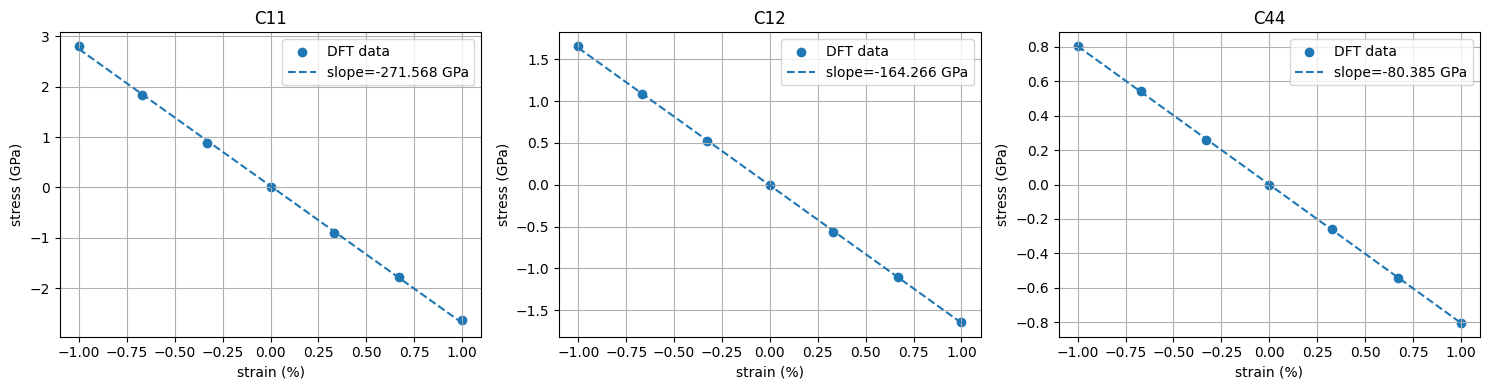


=== Elastic Constants (GPa) ===
C11 = 271.568283 GPa
C12 = 164.265857 GPa
(C11 - C12)/2 = 53.651213 GPa
C44 = 80.384698 GPa


In [ ]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

parent_dir = "../vasp_inputs_elastic"

# --- Parse strain from folder name ---
def parse_strain(folder_name):
    m = re.search(r"([-+]?\d+\.\d+)", folder_name)
    return float(m.group(1)) if m else None

# --- Read last 'in kB' stress line and return 6-component array in GPa ---
def read_last_stress_components(outcar_path):
    stress_line = None
    with open(outcar_path, "r") as f:
        for line in f:
            if "in kB" in line:
                stress_line = line.strip()
    if stress_line is None:
        raise ValueError(f"No 'in kB' line in {outcar_path}")
    parts = stress_line.split()
    nums = [float(x) for x in parts[2:8]]  # Sxx, Syy, Szz, Sxy, Sxz, Syz
    return np.array(nums) * 0.1  # convert kB to GPa

# --- Collect data ---
folders = sorted([d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))])
full_data = {}
for folder in folders:
    strain = parse_strain(folder)
    outcar = os.path.join(parent_dir, folder, "OUTCAR")
    if strain is None or not os.path.isfile(outcar):
        continue
    try:
        comps = read_last_stress_components(outcar)
        full_data[folder] = (strain, comps)
    except Exception:
        pass  # silently skip failed parses

# --- Group by deformation type ---
groups = {"C11": [], "C12": [], "C44": []}
for f, (strain, comps) in full_data.items():
    if "C11" in f:
        groups["C11"].append((strain, comps[0]))  # σxx from εxx
    elif "C12" in f:
        groups["C12"].append((strain, comps[0]))  # σxx from εyy
    elif "C44" in f:
        groups["C44"].append((strain, comps[3]))  # σxy from εxy

# --- Linear fit helper with zero-shift ---
def fit_stats_shifted(points):
    points = sorted(points, key=lambda x: x[0])
    eps = np.array([p[0] for p in points])
    sig = np.array([p[1] for p in points])
    
    # Shift stress so that stress at zero strain = 0
    zero_index = np.argmin(np.abs(eps))  # closest to zero
    sig_shifted = sig - sig[zero_index]

    coeff = np.polyfit(eps, sig_shifted, 1)
    pred = np.polyval(coeff, eps)
    return {
        "slope": coeff[0],  
        "intercept": coeff[1],  # will be ~0 after shift
        "r2": r2_score(sig_shifted, pred),
        "mae": mean_absolute_error(sig_shifted, pred),
        "eps": eps,
        "sig": sig_shifted,
        "pred": pred,
    }

# --- Fit each group using shifted stress for C11 and C12 ---
results = {}
for k in ["C11","C12","C44"]:
    if len(groups[k]) >= 2:
        results[k] = fit_stats_shifted(groups[k])


# --- Plot fits ---
plt.figure(figsize=(15,4))
for i, k in enumerate(["C11","C12","C44"], 1):
    if k not in results:
        continue
    r = results[k]
    ax = plt.subplot(1,3,i)
    ax.scatter(r['eps']*100, r['sig'], label='DFT data')
    ax.plot(r['eps']*100, r['pred'], '--', label=f"slope={r['slope']:.3f} GPa")
    ax.set_xlabel("strain (%)")
    ax.set_ylabel("stress (GPa)")
    ax.set_title(f"{k}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig("elastic_fits.png", dpi=300)
plt.show()

# --- Final elastic constants ---
C11 = results["C11"]["slope"] if "C11" in results else None
C12 = results["C12"]["slope"] if "C12" in results else None
C44 = results["C44"]["slope"] if "C44" in results else None

print("\n=== Elastic Constants (GPa) ===")
if C11 is not None:
    print(f"C11 = {np.abs(C11):.6f} GPa")
if C12 is not None:
    print(f"C12 = {np.abs(C12):.6f} GPa")
if C11 is not None and C12 is not None:
    print(f"(C11 - C12)/2 = {(np.abs(C11) - np.abs(C12))/2:.6f} GPa")
if C44 is not None:
    print(f"C44 = {np.abs(C44):.6f} GPa")

/home/jovyan/shared-scratch-kabdelma-pvc/kabdelma/elastic_mlps/fairchem/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jovyan/shared-scratch-kabdelma-pvc/kabdelma/elastic_mlps/fairchem/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model fie

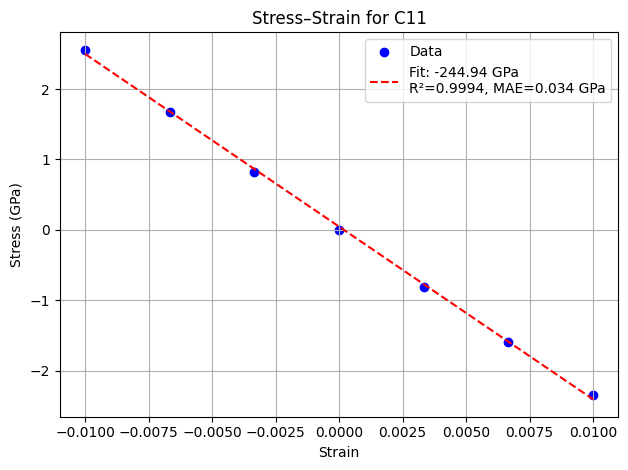

Calculating C12: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


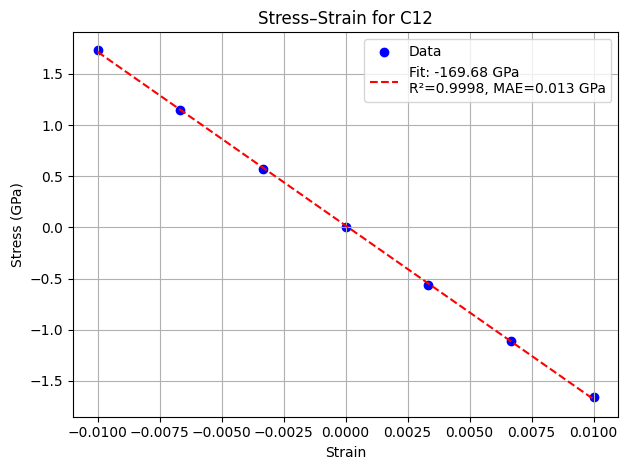

Calculating C44: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


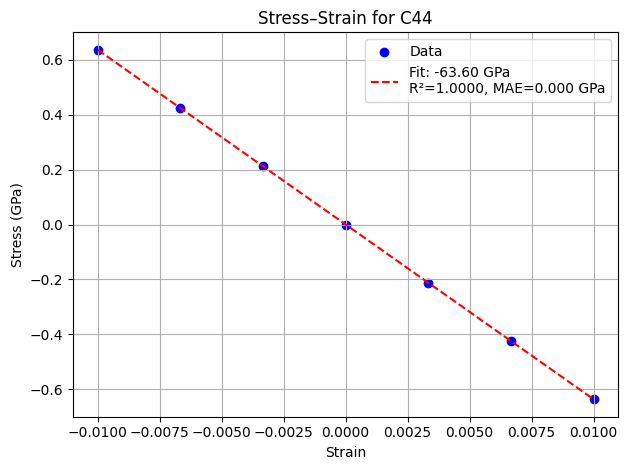


Elastic constants and fit quality:
Label    C (GPa)           R²       MAE (GPa)
----------------------------------------
C11      -244.94     0.999378        0.033910
C12      -169.68     0.999817        0.012860
C44       -63.60     1.000000        0.000206

(C11 - C12)/2 = -37.63 GPa


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ase.optimize import BFGS
from ase.lattice.cubic import BodyCenteredCubic
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- User parameters ---
num_points = 7
max_strain = 0.01      # ±1% strain
fmax_relax = 0.0001
bfgs_steps = 2000
relax_internal = True
EVA3_to_GPa = 160.21766208

# --- Initialize BCC Ta ---
atoms = BodyCenteredCubic('Ta')
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# Fully relax the structure
atoms.calc = calc
opt = BFGS(atoms, logfile=None)
opt.run(fmax=0.0001, steps=bfgs_steps)
cell0 = atoms.get_cell().copy()

# --- Compute zero-strain stress ---
atoms.set_cell(cell0, scale_atoms=True)
atoms.calc = calc
calc.relax_cell = False
if relax_internal:
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=fmax_relax, steps=bfgs_steps)

stress_zero = atoms.get_stress(voigt=False)  # to shift all stresses

# --- Strain types ---
strain_types = {
    "C11": {"type": "normal", "strain_dir": 0, "stress_dir": 0},
    "C12": {"type": "normal", "strain_dir": 0, "stress_dir": 1},
    "C44": {"type": "shear",  "strain_dir": (0, 1), "stress_dir": (0, 1)},
}

C_results = {}
R2_results = {}
MAE_results = {}

# --- Loop over strain types ---
for label, info in strain_types.items():
    strains = np.linspace(-max_strain, max_strain, num_points)
    stresses = []

    for eps in tqdm(strains, desc=f"Calculating {label}"):
        strain_matrix = np.eye(3)

        # Build deformation
        if info["type"] == "shear":
            i, j = info["strain_dir"]
            strain_matrix[i, j] = eps
        else:
            i = info["strain_dir"]
            strain_matrix[i, i] = 1 + eps

        # Apply strain
        new_cell = np.dot(cell0, strain_matrix)
        atoms.set_cell(new_cell, scale_atoms=True)
        atoms.calc = calc
        calc.relax_cell = False

        # Relax internal coordinates only
        if relax_internal:
            opt = BFGS(atoms, logfile=None)
            opt.run(fmax=fmax_relax, steps=bfgs_steps)

        # Get stress component and subtract zero-strain stress
        stress = atoms.get_stress(voigt=False) - stress_zero
        if info["type"] == "shear":
            i, j = info["stress_dir"]
            val = float(stress[i, j])
        else:
            i = info["stress_dir"]
            val = float(stress[i, i])

        # --- Flip sign for all to match DFT negative slopes ---
        val = -val
        stresses.append(val)

    stresses = np.array(stresses)

    # --- Linear regression ---
    coeffs = np.polyfit(strains, stresses, 1)
    fit_line = np.polyval(coeffs, strains)
    C_value = coeffs[0] * EVA3_to_GPa
    C_results[label] = C_value

    # --- Goodness of fit ---
    ss_res = np.sum((stresses - fit_line) ** 2)
    ss_tot = np.sum((stresses - np.mean(stresses)) ** 2)
    r2 = 1 - ss_res / ss_tot
    R2_results[label] = r2

    mae = np.mean(np.abs((stresses - fit_line) * EVA3_to_GPa))
    MAE_results[label] = mae

    # --- Plot ---
    plt.figure()
    plt.scatter(strains, stresses * EVA3_to_GPa, color='blue', label='Data')
    plt.plot(strains, fit_line * EVA3_to_GPa, 'r--', 
             label=f'Fit: {C_value:.2f} GPa\nR²={r2:.4f}, MAE={mae:.3f} GPa')
    plt.xlabel('Strain')
    plt.ylabel('Stress (GPa)')
    plt.title(f'Stress–Strain for {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Final results ---
print("\nElastic constants and fit quality:")
print(f"{'Label':<5} {'C (GPa)':>10} {'R²':>12} {'MAE (GPa)':>15}")
print("-" * 40)
for k in C_results:
    print(f"{k:<5} {C_results[k]:>10.2f} {R2_results[k]:>12.6f} {MAE_results[k]:>15.6f}")

if 'C11' in C_results and 'C12' in C_results:
    print("\n(C11 - C12)/2 = {:.2f} GPa".format((C_results['C11'] - C_results['C12'])/2))


In [4]:
C_results

{'C11': np.float64(-244.9398267210194),
 'C12': np.float64(-169.67611425364862),
 'C44': np.float64(-63.60145944582836)}